In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler


In [82]:
# Load the dataset from the provided file "train.csv"
file_path = 'train.csv'  # Update the file path as required
# load the dataset into a pandas dataframe and drop the id column
df = pd.read_csv(file_path)
df = df.drop(columns=['Id'])

In [83]:
print(df.info())  # Check data types and non-null counts
print(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           15120 non-null  int64
 1   Aspect                              15120 non-null  int64
 2   Slope                               15120 non-null  int64
 3   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 4   Vertical_Distance_To_Hydrology      15120 non-null  int64
 5   Horizontal_Distance_To_Roadways     15120 non-null  int64
 6   Hillshade_9am                       15120 non-null  int64
 7   Hillshade_Noon                      15120 non-null  int64
 8   Hillshade_3pm                       15120 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 10  Wilderness_Area1                    15120 non-null  int64
 11  Wilderness_Area2                    15120 non-null  int64
 12  Wild

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2881,130,22,210,54,1020,250,221,88,342,...,0,0,0,0,0,0,0,0,0,1
1,3005,351,14,242,-16,1371,194,215,159,842,...,0,0,0,0,0,0,0,0,0,1
2,3226,63,14,618,2,1092,232,210,107,2018,...,0,0,0,0,0,0,0,0,0,1
3,3298,317,8,661,60,752,198,233,174,1248,...,0,0,0,0,0,0,0,0,0,1
4,3080,35,6,175,26,3705,219,227,144,2673,...,0,0,0,0,0,0,0,0,0,1


In [84]:
# Select only the soil_type columns
soil_columns = [col for col in df.columns if col.startswith('Soil_Type')]

# Count the number of 0's and 1's in each soil_type column
zero_one_counts = pd.DataFrame({
    'Zeros': (df[soil_columns] == 0).sum(),
    'Ones': (df[soil_columns] == 1).sum()
})

# Display the counts
print(zero_one_counts)


             Zeros  Ones
Soil_Type1   14781   339
Soil_Type2   14493   627
Soil_Type3   14114  1006
Soil_Type4   14281   839
Soil_Type5   14939   181
Soil_Type6   14441   679
Soil_Type7   15119     1
Soil_Type8   15118     2
Soil_Type9   15116     4
Soil_Type10  13024  2096
Soil_Type11  14744   376
Soil_Type12  14860   260
Soil_Type13  14607   513
Soil_Type14  14947   173
Soil_Type15  15120     0
Soil_Type16  15014   106
Soil_Type17  14480   640
Soil_Type18  15076    44
Soil_Type19  15067    53
Soil_Type20  14988   132
Soil_Type21  15110    10
Soil_Type22  14788   332
Soil_Type23  14378   742
Soil_Type24  14855   265
Soil_Type25  15114     6
Soil_Type26  15072    48
Soil_Type27  15112     8
Soil_Type28  15113     7
Soil_Type29  13812  1308
Soil_Type30  14384   736
Soil_Type31  14816   304
Soil_Type32  14457   663
Soil_Type33  14501   619
Soil_Type34  15102    18
Soil_Type35  15017   103
Soil_Type36  15106    14
Soil_Type37  15088    32
Soil_Type38  14376   744
Soil_Type39  14486   634


In [85]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Check for NaNs and fill if needed
df = df.fillna(0)  # Replace NaNs with 0, or use another method as appropriate

# Step 1: Apply log transformation to skewed columns, handling negative values by adding a constant
skewed_columns = [
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Horizontal_Distance_To_Fire_Points',
    'Hillshade_3pm',
    "Hillshade_9am",
    "Hillshade_Noon"
]

sparse_columns = zero_one_counts[zero_one_counts['Ones'] < 10].index
df = df.drop(columns=sparse_columns)

# Apply the log transformation and handle negative values by shifting
for col in skewed_columns:
    # Shift values if necessary to make them positive before applying log
    min_value = df[col].min()
    shift = 1 - min_value if min_value <= 0 else 0
    df[f'log_{col}'] = np.log(df[col] + shift + 1)

# Step 2: Drop original skewed columns
df = df.drop(columns=skewed_columns)

# Step 3: Normalize the entire dataset (including the log-transformed columns)
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Display the normalized DataFrame
print(df_normalized.head())


   Elevation    Aspect  Slope  Wilderness_Area1  Wilderness_Area2  \
0   0.508870  0.361111   0.44               1.0               0.0   
1   0.571718  0.975000   0.28               0.0               0.0   
2   0.683730  0.175000   0.28               1.0               0.0   
3   0.720223  0.880556   0.16               0.0               1.0   
4   0.609731  0.097222   0.12               1.0               0.0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0               0.0               0.0         0.0         0.0         0.0   
1               1.0               0.0         0.0         0.0         0.0   
2               0.0               0.0         0.0         0.0         0.0   
3               0.0               0.0         0.0         0.0         0.0   
4               0.0               0.0         0.0         0.0         0.0   

   ...  Soil_Type39  Soil_Type40  Cover_Type  \
0  ...          0.0          0.0         0.0   
1  ...          0.0       

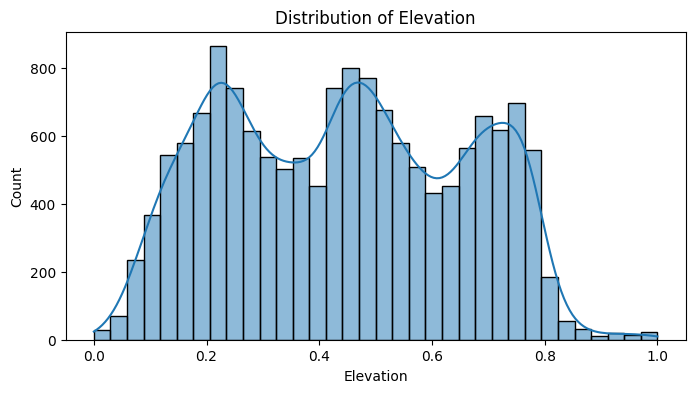

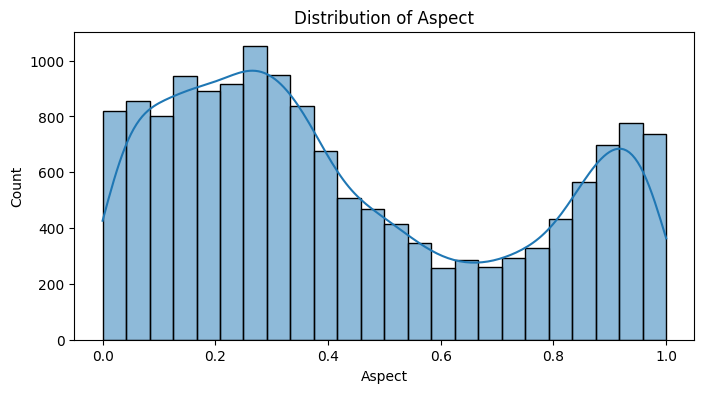

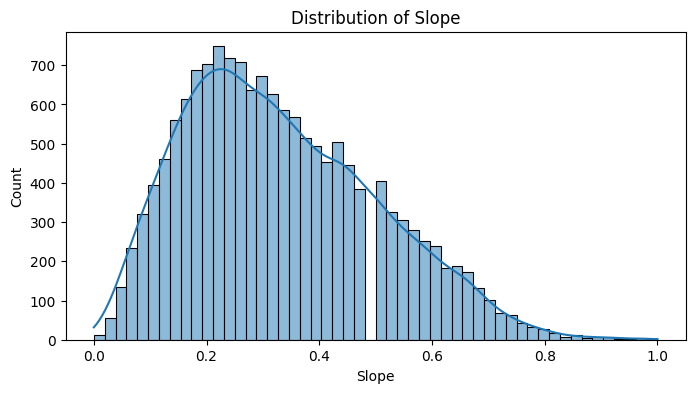

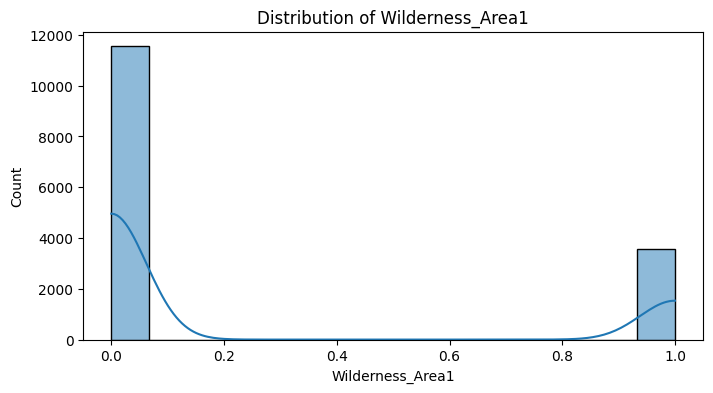

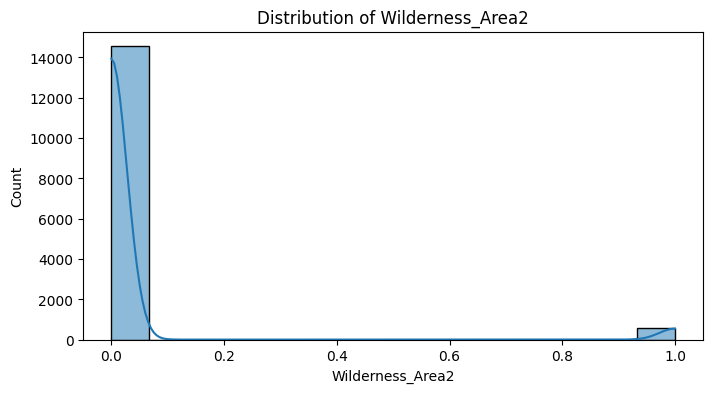

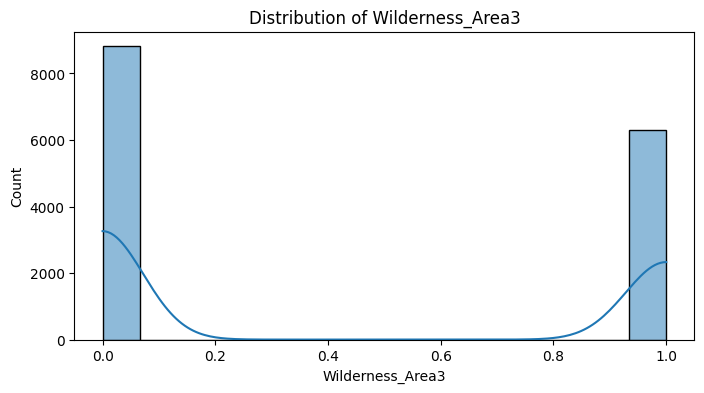

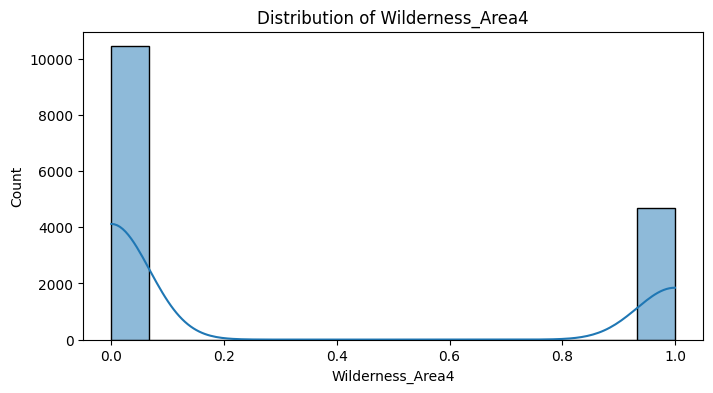

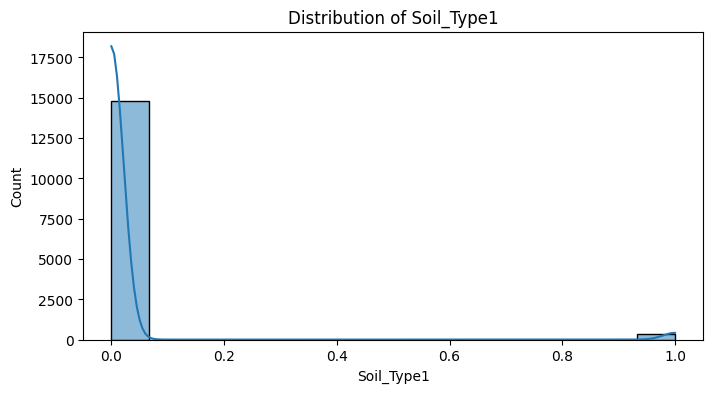

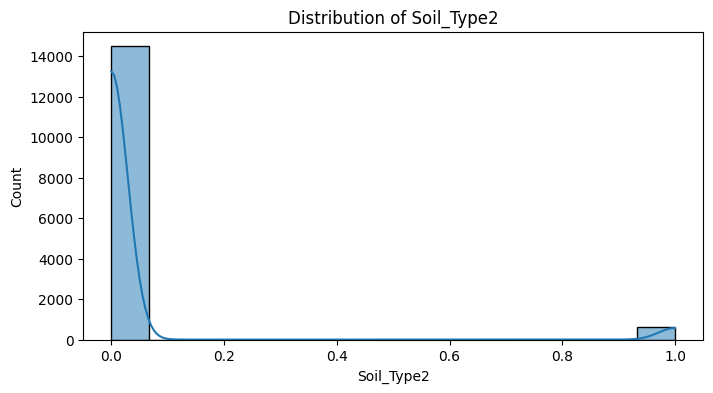

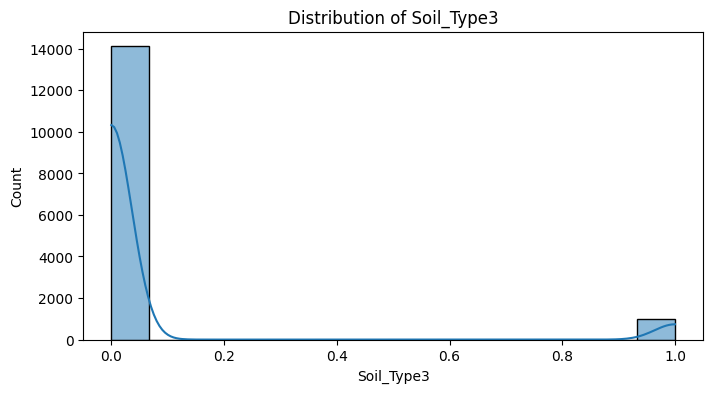

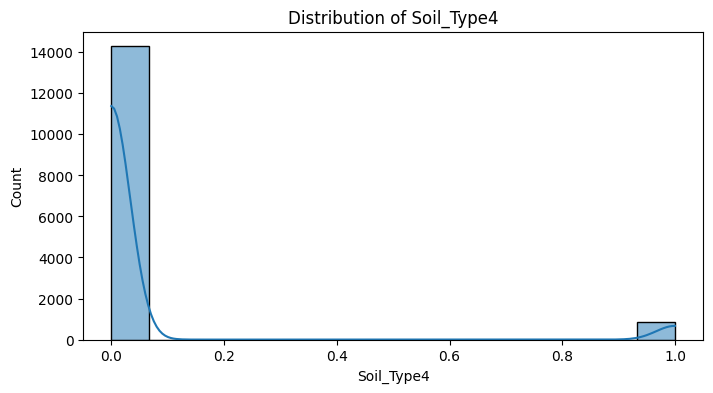

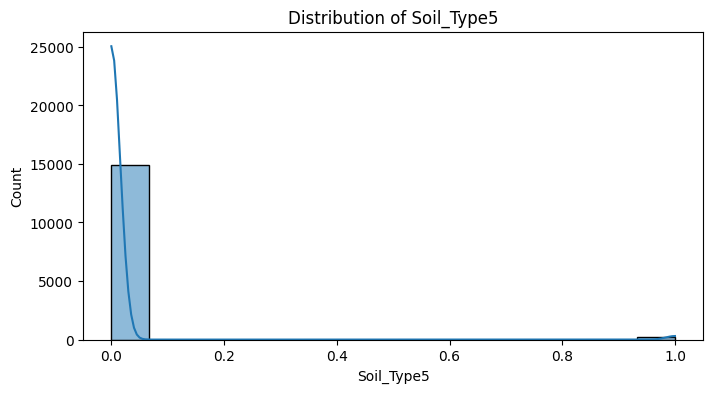

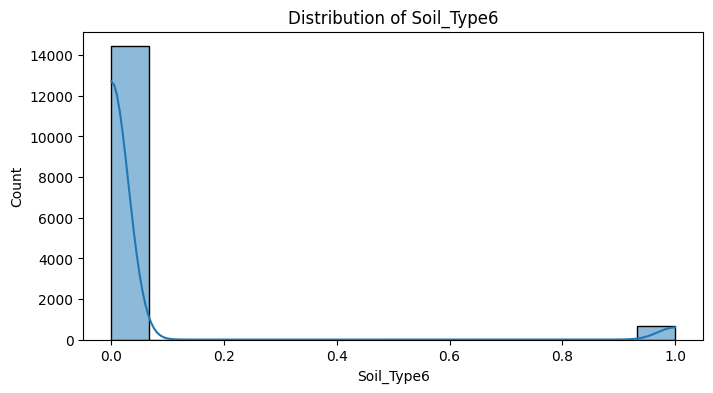

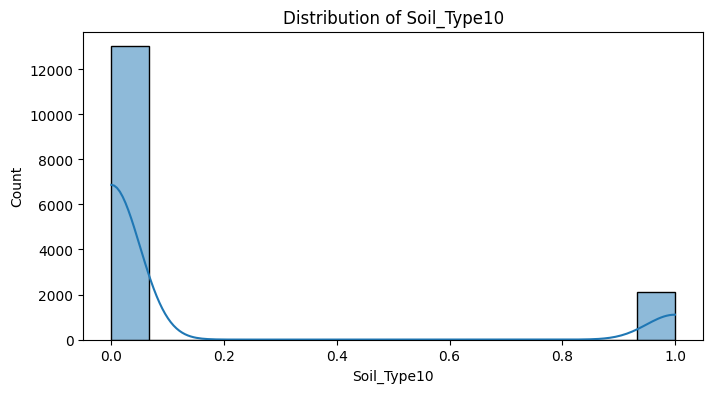

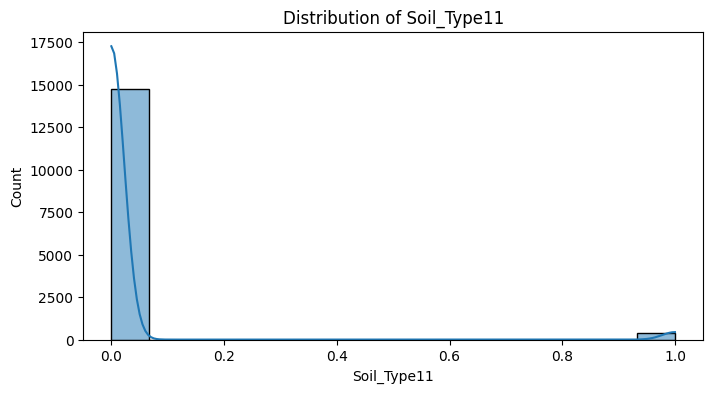

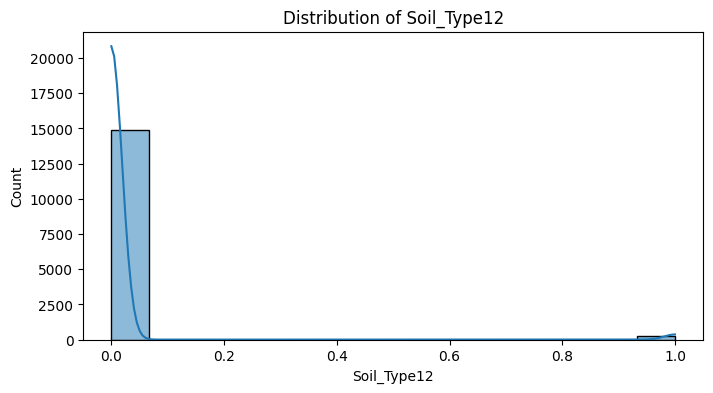

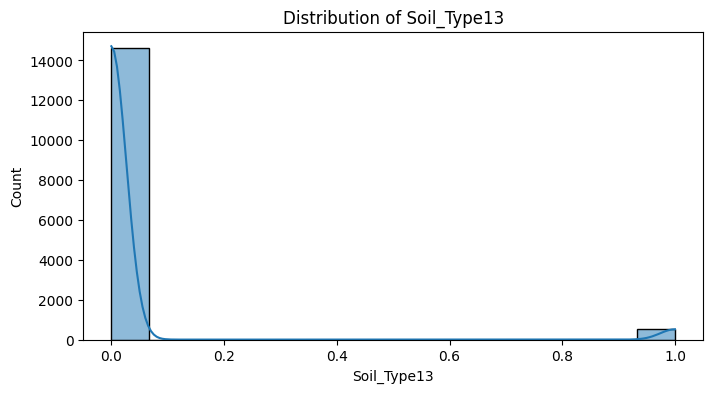

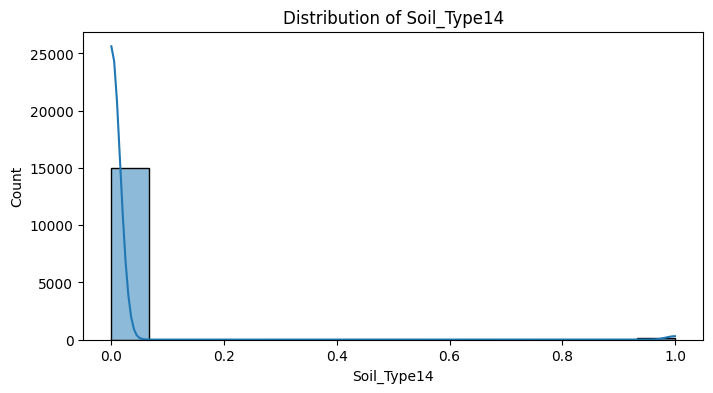

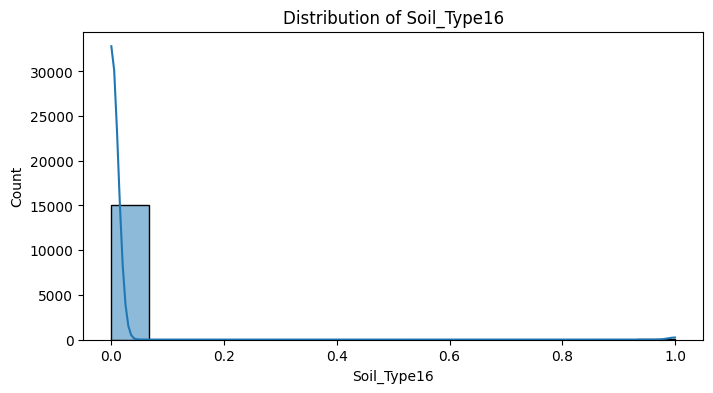

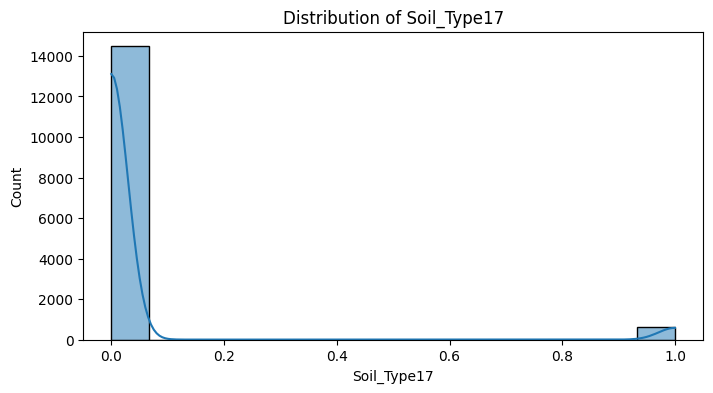

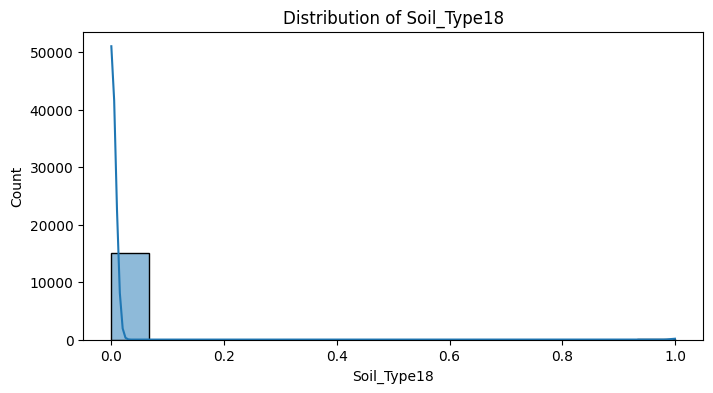

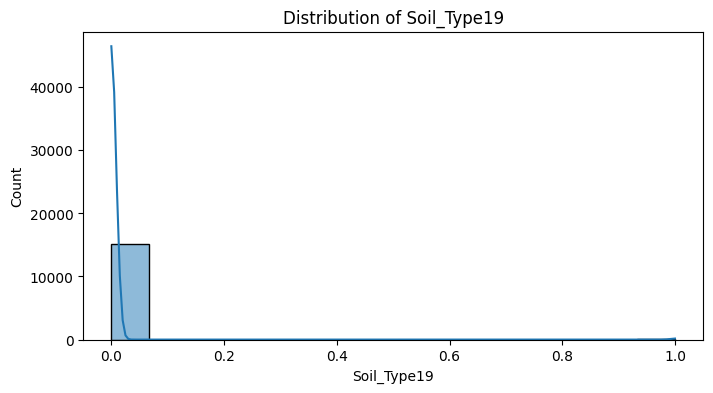

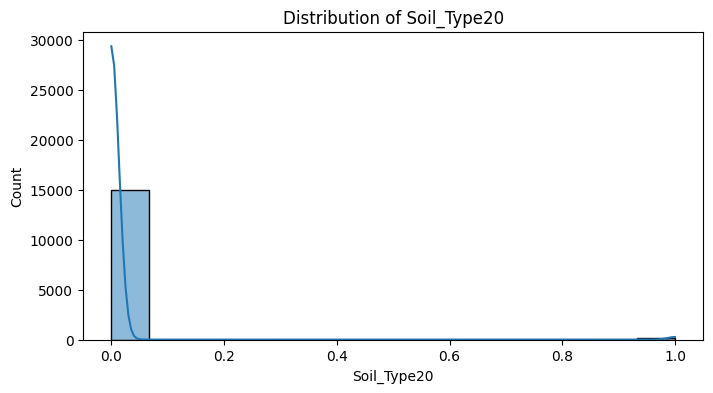

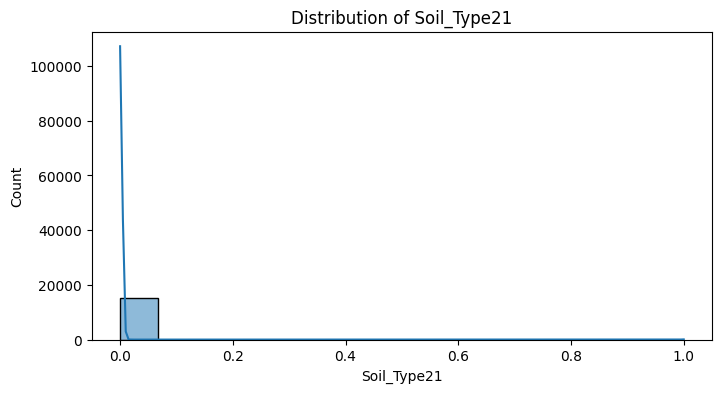

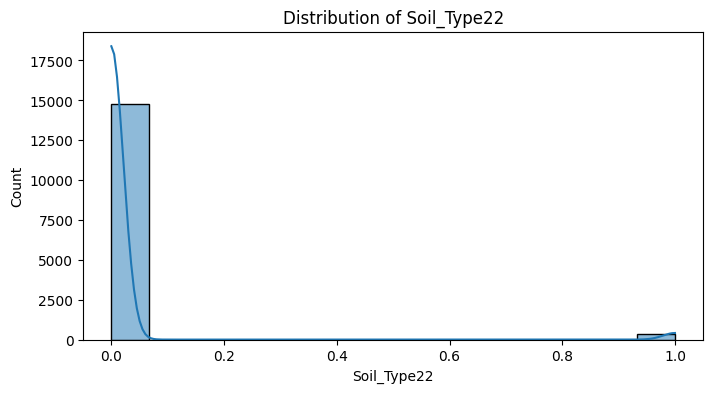

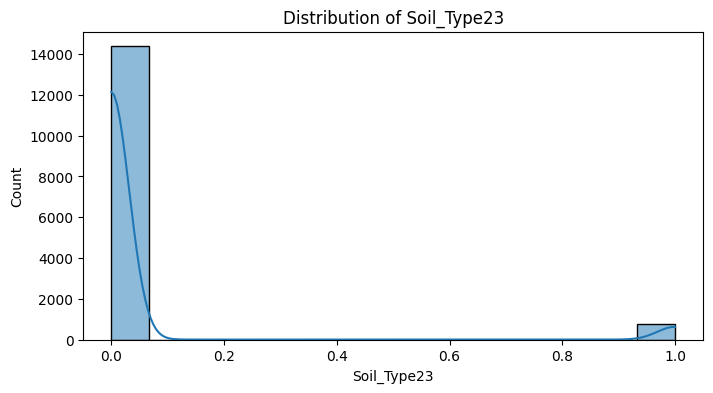

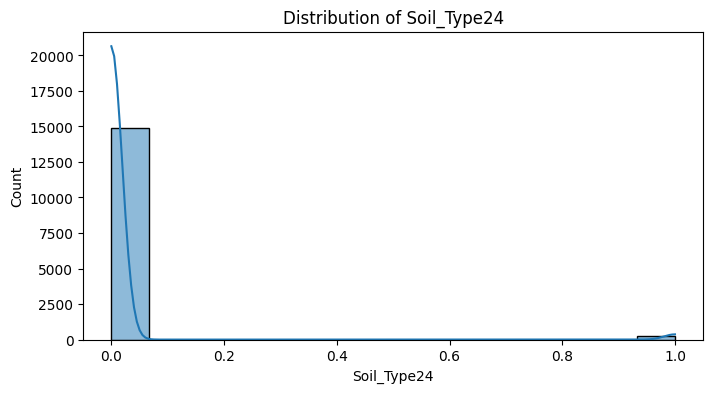

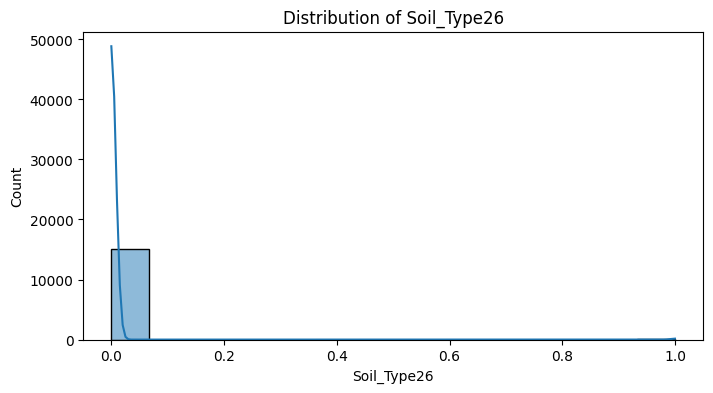

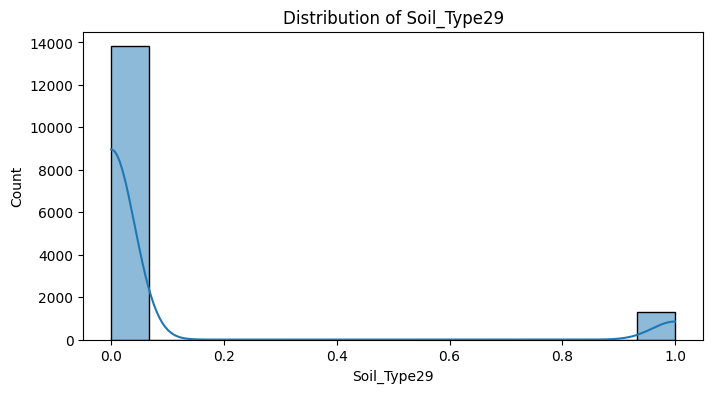

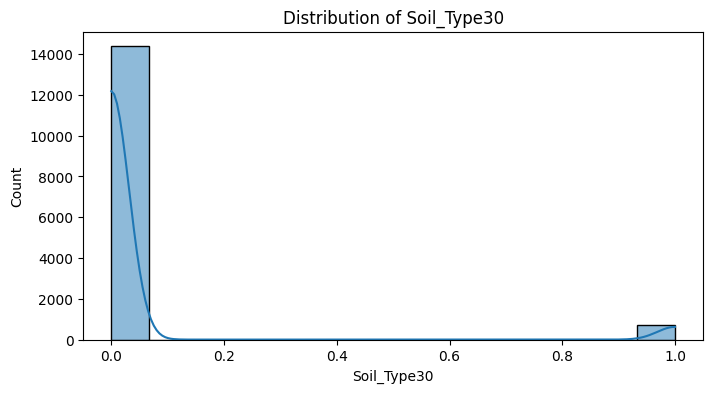

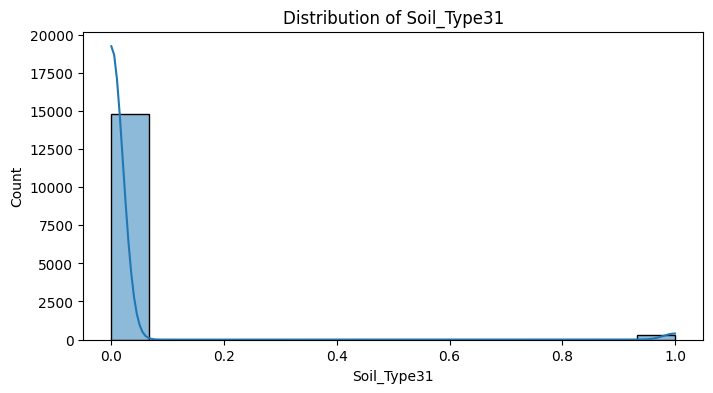

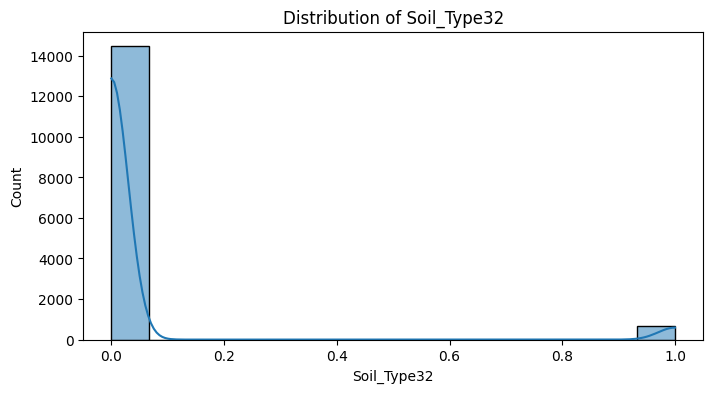

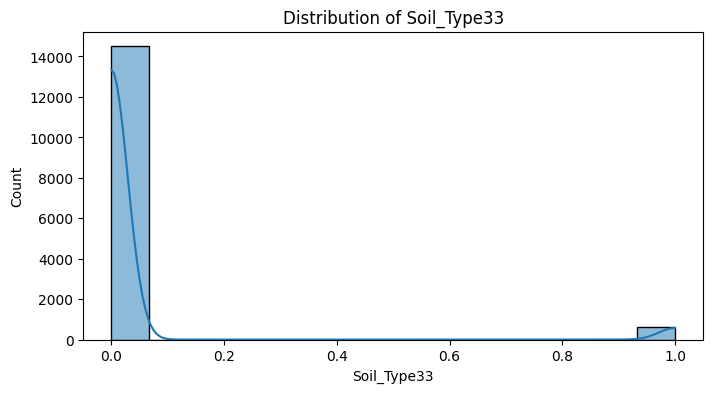

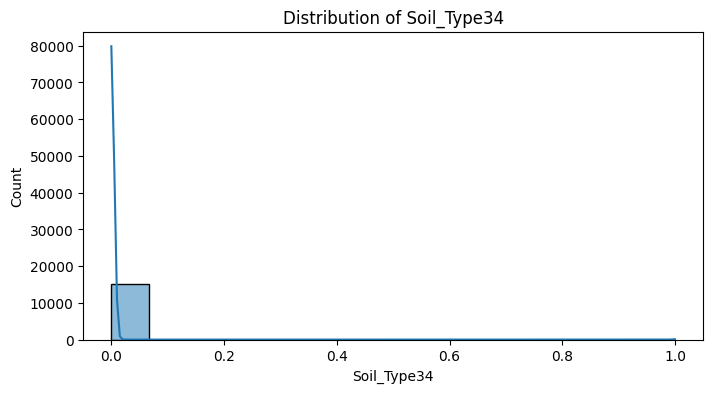

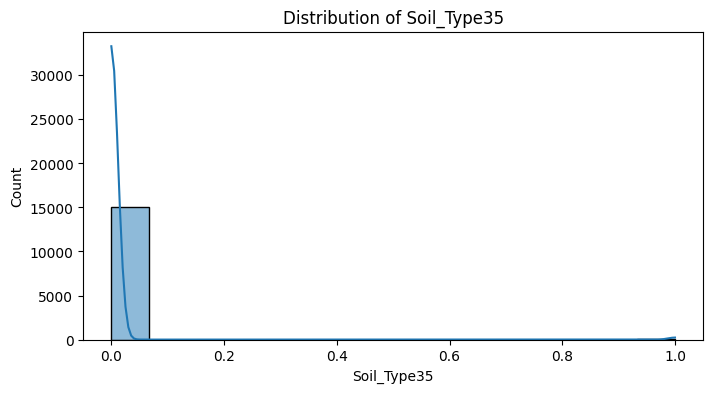

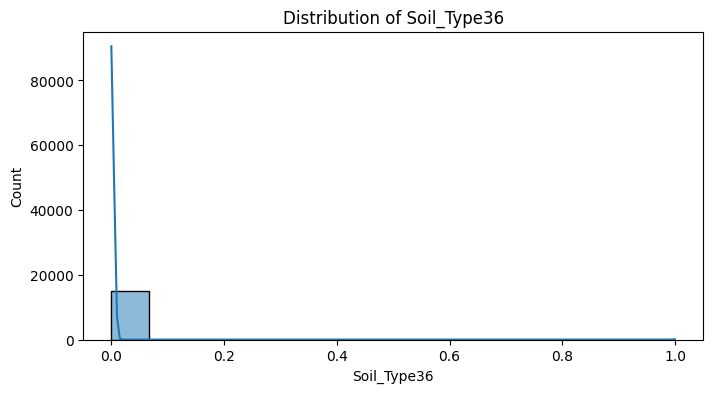

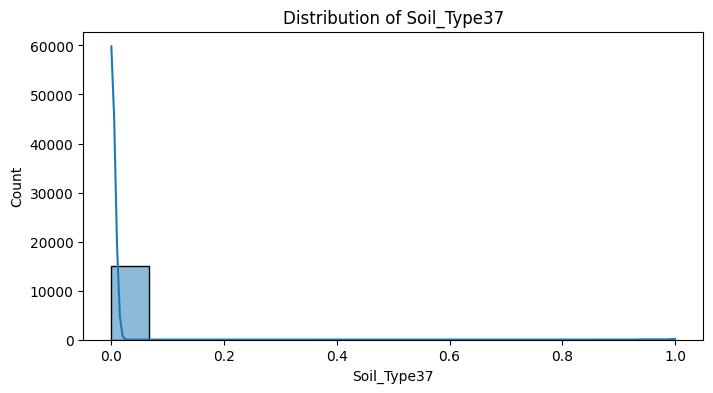

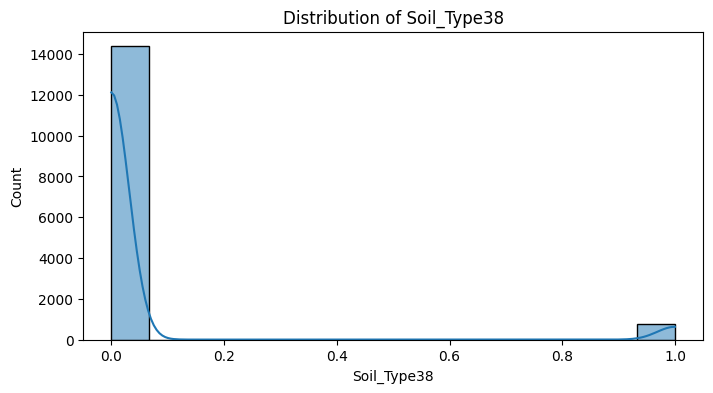

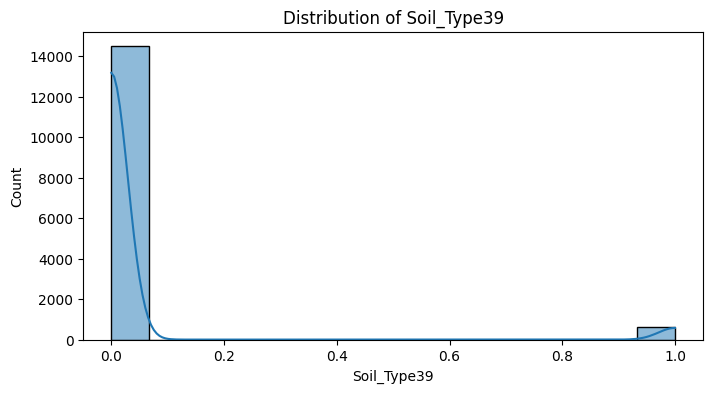

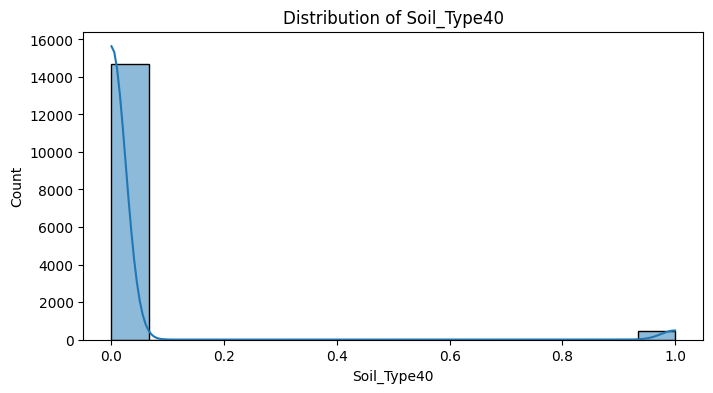

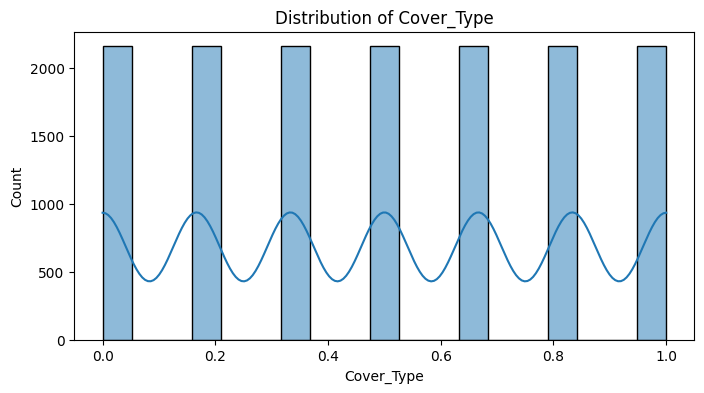

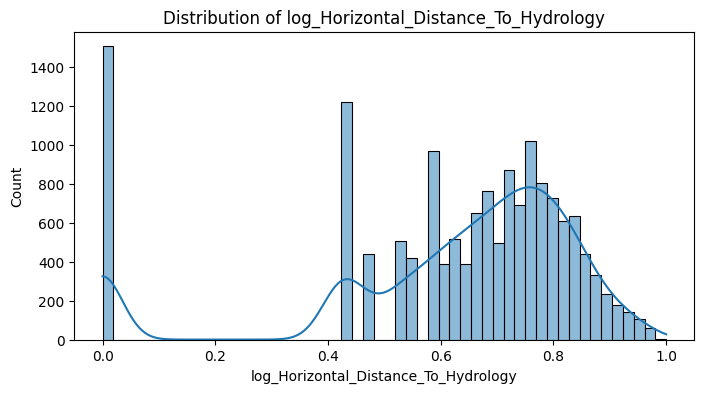

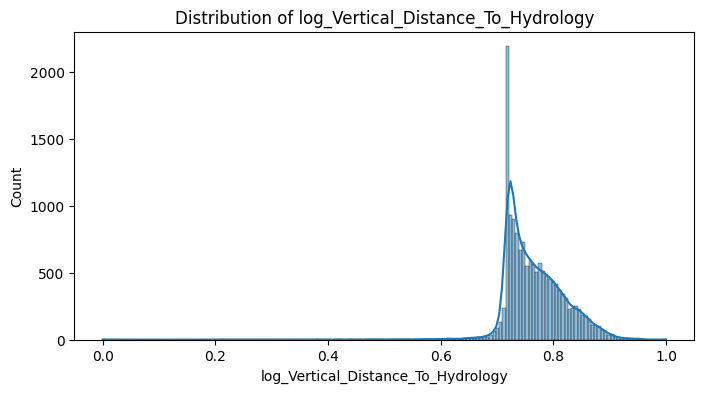

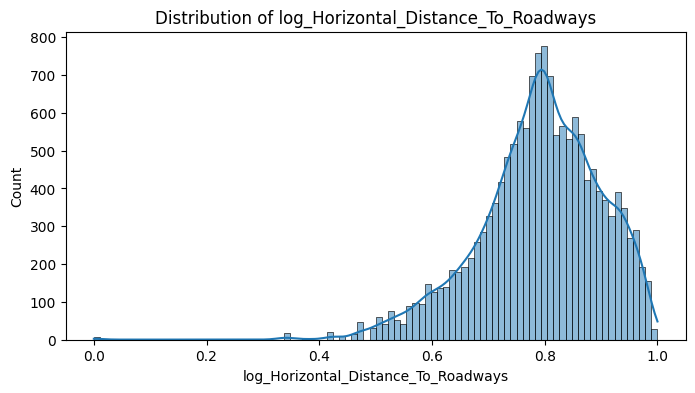

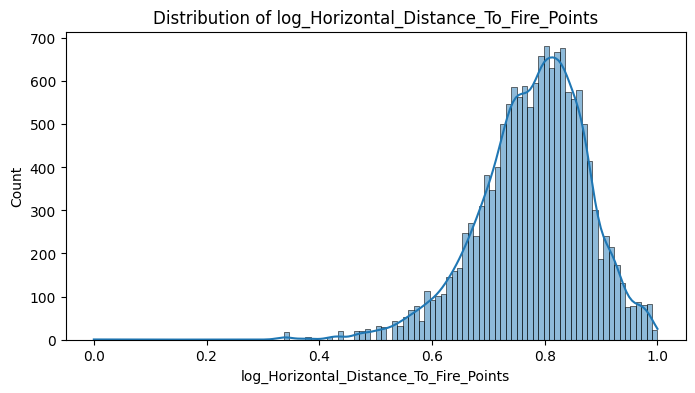

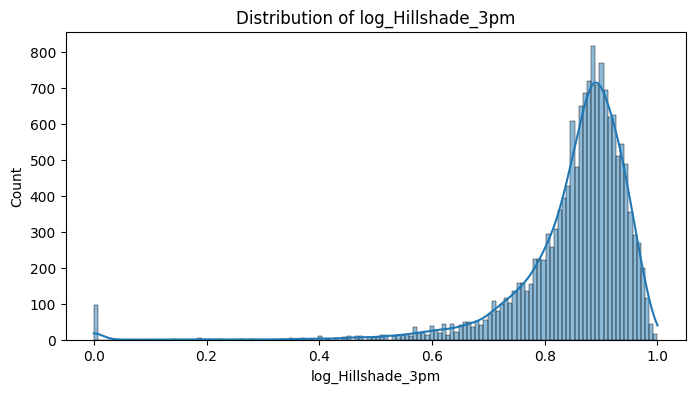

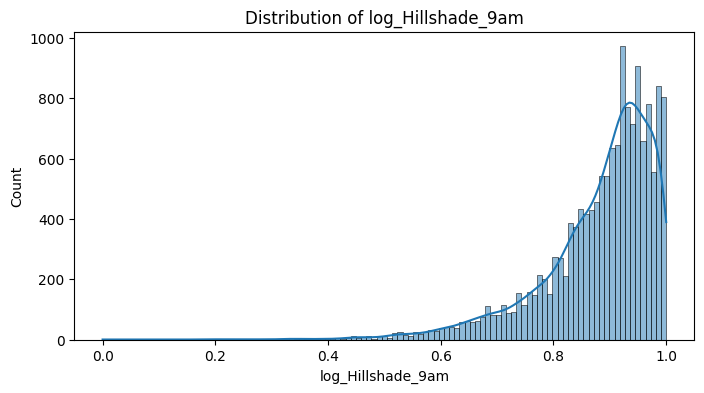

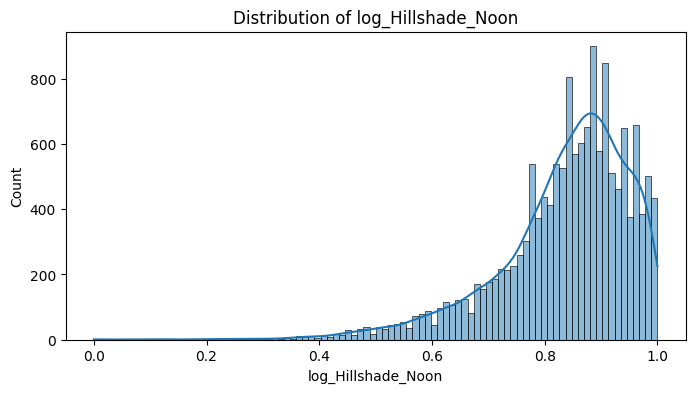

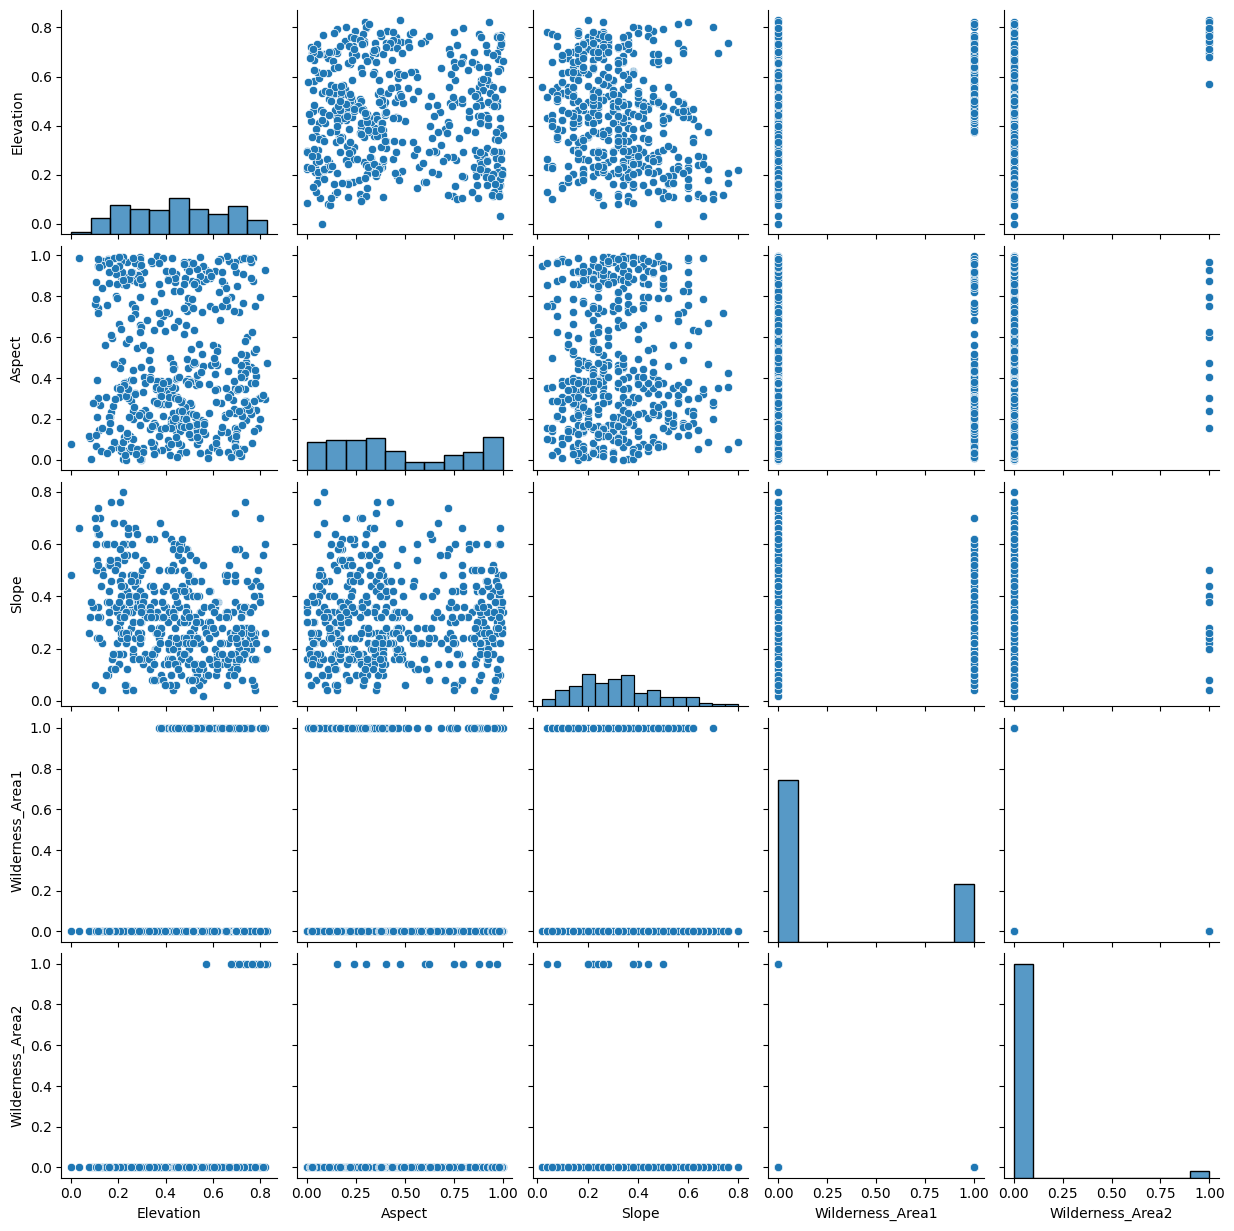

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df_normalized
# Histograms for each numerical column to see distributions
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()
    plt.close()  # Close figure to free memory

# Pairplot for pairwise relationships between a subset of numerical variables
# Limit to a sample of rows and subset of columns if needed
subset_columns = numerical_columns[:5]  # Choose a manageable subset, e.g., first 5 numerical columns
df_sample = df[subset_columns].sample(n=500, random_state=1)  # Sample 500 rows for faster plotting

sns.pairplot(df_sample)
plt.show()


In [88]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Assuming df is your DataFrame with the original features

# Step 1: Initialize PCA with the number of components equal to the number of columns
n_components = len(df.columns)  # Set the number of components to match the number of columns
pca = PCA(n_components=n_components)

# Step 2: Fit the PCA model without transforming the data yet
pca.fit(df)

# Step 3: Calculate the explained variance contribution of each original feature
explained_variance_by_feature = {}

# Loop through each feature and calculate its contribution to the total explained variance
for i, feature in enumerate(df.columns):
    # Calculate the contribution of each feature to the variance of each principal component
    feature_contribution = np.square(pca.components_[:, i]) * pca.explained_variance_ratio_
    
    # Sum up the contribution across all components to get the total explained variance for each feature
    explained_variance_by_feature[feature] = feature_contribution.sum()

# Step 4: Sort features by explained variance in descending order
sorted_explained_variance = sorted(explained_variance_by_feature.items(), key=lambda x: x[1], reverse=True)

# Step 5: Print the sorted explained variance by original feature
print("Explained variance by each original feature (sorted):")
for feature, variance in sorted_explained_variance:
    print(f"{feature}: {variance:.4f}")


Explained variance by each original feature (sorted):
Wilderness_Area3: 0.1208
Wilderness_Area4: 0.1062
Wilderness_Area1: 0.0896
Soil_Type10: 0.0593
Cover_Type: 0.0552
Aspect: 0.0462
Soil_Type29: 0.0393
Soil_Type3: 0.0309
log_Horizontal_Distance_To_Hydrology: 0.0295
Soil_Type4: 0.0260
Soil_Type38: 0.0233
Soil_Type23: 0.0232
Soil_Type30: 0.0230
Elevation: 0.0224
Soil_Type6: 0.0213
Soil_Type32: 0.0208
Soil_Type17: 0.0201
Soil_Type39: 0.0200
Soil_Type2: 0.0198
Soil_Type33: 0.0195
Wilderness_Area2: 0.0180
Soil_Type13: 0.0163
Soil_Type40: 0.0145
Slope: 0.0145
Soil_Type11: 0.0121
Soil_Type1: 0.0109
Soil_Type22: 0.0107
Soil_Type31: 0.0098
Soil_Type24: 0.0086
Soil_Type12: 0.0084
log_Hillshade_Noon: 0.0070
log_Hillshade_3pm: 0.0061
Soil_Type5: 0.0059
log_Horizontal_Distance_To_Roadways: 0.0058
Soil_Type14: 0.0056
log_Hillshade_9am: 0.0052
log_Horizontal_Distance_To_Fire_Points: 0.0045
Soil_Type20: 0.0043
Soil_Type16: 0.0035
Soil_Type35: 0.0034
Soil_Type19: 0.0017
Soil_Type26: 0.0016
Soil_Type18